In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.0 MB/s eta 0:00:00


In [2]:

import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, LeakyReLU, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers

import keras_tuner as kt
from keras_tuner import HyperParameters



TPU found!
TPU initialized.


Loading in the data

In [3]:
random.seed(1)
tf.random.set_seed(1)
# Set working directory
from google.colab import drive
drive.mount('/content/drive')


merged_data = pd.read_csv('/content/drive/My Drive/data/merged_data.csv')


data = merged_data.copy()
data['Date'] = pd.to_datetime(data['Date'])
# Get the start and end dates
start_date = data['Date'].min()
end_date = data['Date'].max()

print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")

Mounted at /content/drive
Start Date: 2023-01-01 18:00:00
End Date: 2023-12-29 16:00:00


Preparing data

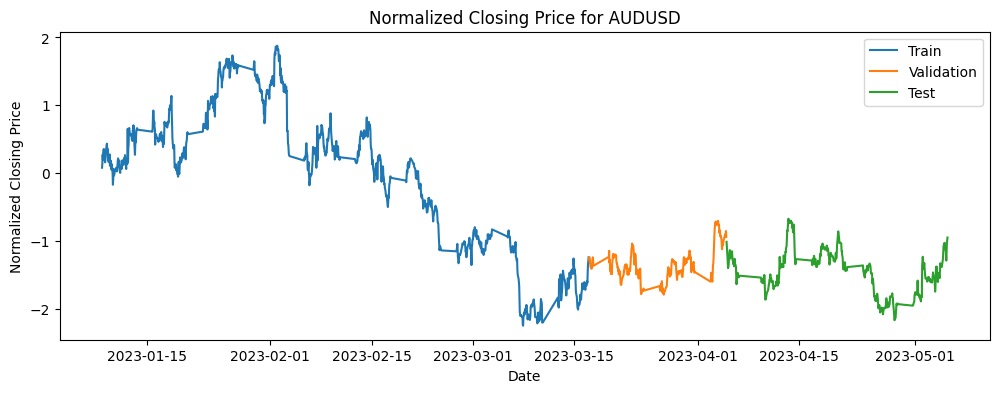

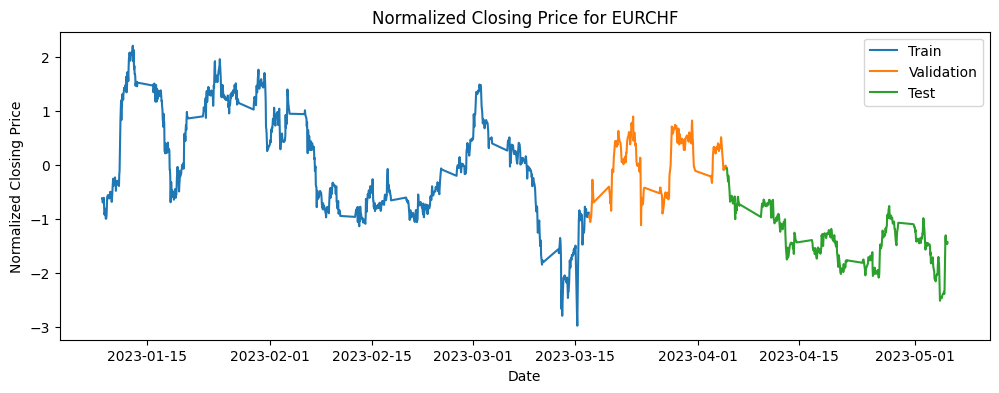

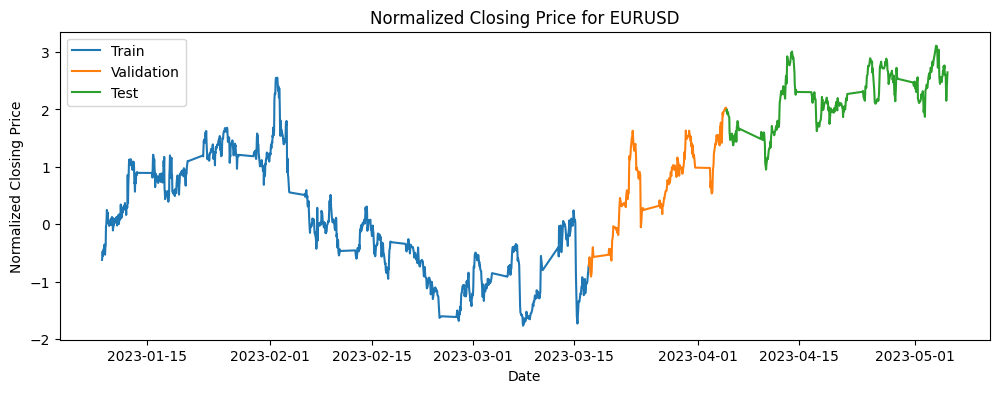

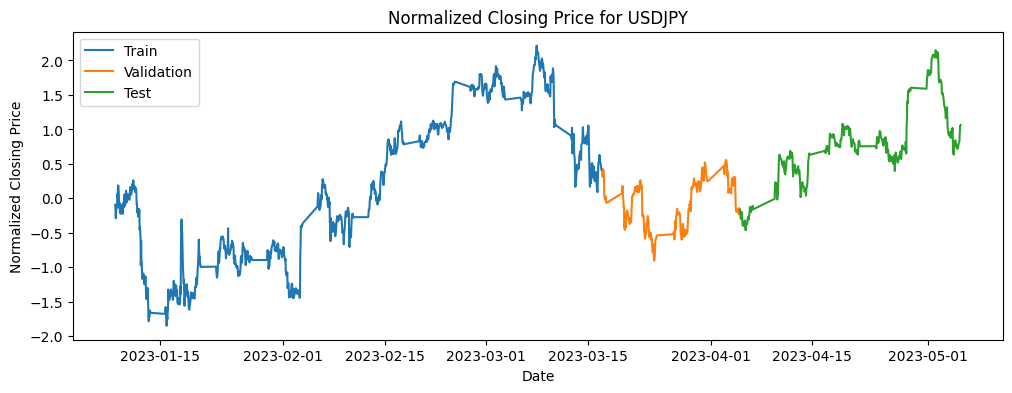

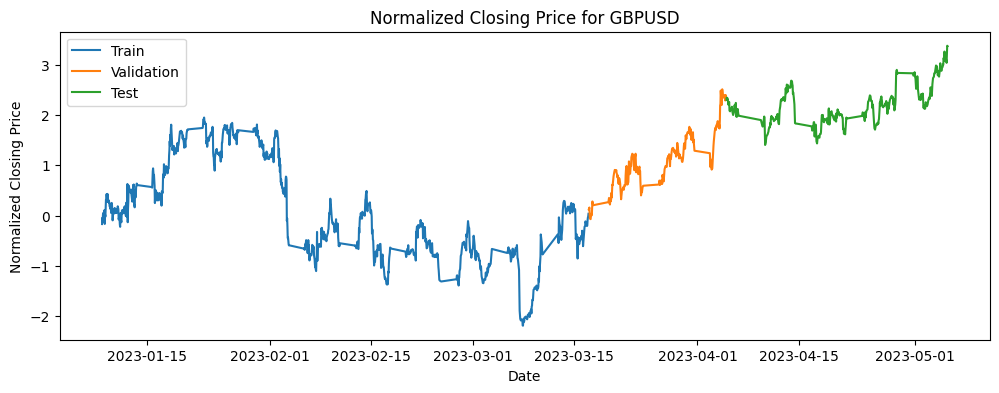

X_train shape: (5227, 120, 4)
y_train shape: (5227,)
X_val shape: (1095, 120, 4)
y_val shape: (1095,)
X_test shape: (1860, 120, 4)
y_test shape: (1860,)


In [4]:


data['Date'] = pd.to_datetime(data['Date'])

features = ['closing_price', 'high', 'low', 'opening_price']
timesteps = 120  # Number of past time steps

# Define your date ranges
train_end_date = pd.to_datetime("2023-03-16 23:59:59")
val_start_date = pd.to_datetime("2023-03-17 00:00:00")
val_end_date = pd.to_datetime("2023-04-04 23:59:59")
test_start_date = pd.to_datetime("2023-04-05 00:00:00")
test_end_date = pd.to_datetime("2023-05-05 12:00:00")

# Initialize lists to collect data across tickers
X_train_list = []
y_train_list = []
dates_train_list = []
tickers_train_list = []

X_val_list = []
y_val_list = []
dates_val_list = []
tickers_val_list = []

X_test_list = []
y_test_list = []
dates_test_list = []
tickers_test_list = []

# Dictionaries to store scalers for each ticker
scalers = {}
target_scalers = {}

for ticker in data['ticker'].unique():
    df = data[data['ticker'] == ticker].reset_index(drop=True)
    df = df.sort_values('Date')

    # Fit scaler on training data
    train_df = df[df['Date'] <= train_end_date]
    if len(train_df) < timesteps:
        continue  # Skip ticker if not enough data
    scaler = StandardScaler()
    scaler.fit(train_df[features])

    # Scale the entire dataset using the scaler fitted on training data
    df_scaled = df.copy()
    df_scaled[features] = scaler.transform(df[features])

    # Similarly, fit target scaler on training data
    target_scaler = StandardScaler()
    target_scaler.fit(train_df[['closing_price']])

    # Add scaled closing_price to df_scaled
    df_scaled['closing_price_scaled'] = target_scaler.transform(df[['closing_price']])

    scalers[ticker] = scaler
    target_scalers[ticker] = target_scaler

    def create_sequences(df_scaled, start_date, end_date, timesteps):
        X = []
        y = []
        dates = []
        # Shift 'high' and 'low' by one timestep
        df_scaled['high_shifted'] = df_scaled['high'].shift(1)
        df_scaled['low_shifted'] = df_scaled['low'].shift(1)

        # Drop rows with NaN values after shifting
        df_scaled = df_scaled.dropna().reset_index(drop=True)

        # Update features to exclude 'high' and 'low' and include 'high_shifted' and 'low_shifted'
        adjusted_features = ['closing_price',  'opening_price', 'high_shifted', 'low_shifted']

        # Find the start index
        start_idx = df_scaled.index[df_scaled['Date'] >= start_date][0] - timesteps
        # Ensure start_idx is not negative
        if start_idx < 0:
            start_idx = 0
        # Find the end index
        end_idx = df_scaled.index[df_scaled['Date'] <= end_date][-1]
        for i in range(start_idx, end_idx - timesteps + 1):
            X_seq = df_scaled[adjusted_features].iloc[i:i+timesteps].values
            y_seq = df_scaled['closing_price_scaled'].iloc[i+timesteps]
            date_seq = df_scaled['Date'].iloc[i+timesteps]
            # Only include sequences where the target date is within the desired range
            if date_seq >= start_date and date_seq <= end_date:
                X.append(X_seq)
                y.append(y_seq)
                dates.append(date_seq)
        return np.array(X), np.array(y), dates


    # Create training sequences
    X_train_ticker, y_train_ticker, dates_train_ticker = create_sequences(
        df_scaled, df_scaled['Date'].min(), train_end_date, timesteps)
    # Create validation sequences
    X_val_ticker, y_val_ticker, dates_val_ticker = create_sequences(
        df_scaled, val_start_date, val_end_date, timesteps)
    # Create test sequences
    X_test_ticker, y_test_ticker, dates_test_ticker = create_sequences(
        df_scaled, test_start_date, test_end_date, timesteps)

    # Ensure we have enough data in each split
    if len(X_train_ticker) == 0 or len(X_val_ticker) == 0 or len(X_test_ticker) == 0:
        continue  # Skip ticker if not enough data

    # Append to lists
    X_train_list.append(X_train_ticker)
    y_train_list.append(y_train_ticker)
    dates_train_list.extend(dates_train_ticker)
    tickers_train_list.extend([ticker] * len(y_train_ticker))

    X_val_list.append(X_val_ticker)
    y_val_list.append(y_val_ticker)
    dates_val_list.extend(dates_val_ticker)
    tickers_val_list.extend([ticker] * len(y_val_ticker))

    X_test_list.append(X_test_ticker)
    y_test_list.append(y_test_ticker)
    dates_test_list.extend(dates_test_ticker)
    tickers_test_list.extend([ticker] * len(y_test_ticker))

    # Plot the normalized closing price of each train/val/test
    plt.figure(figsize=(12, 4))
    plt.plot(dates_train_ticker, y_train_ticker, label='Train')
    plt.plot(dates_val_ticker, y_val_ticker, label='Validation')
    plt.plot(dates_test_ticker, y_test_ticker, label='Test')
    plt.title(f'Normalized Closing Price for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Normalized Closing Price')
    plt.legend()
    plt.show()

# Concatenate data from all tickers
# Training data
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
dates_train = np.array(dates_train_list)
tickers_train = np.array(tickers_train_list)

# Validation data
X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)
dates_val = np.array(dates_val_list)
tickers_val = np.array(tickers_val_list)

# Test data
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)
dates_test = np.array(dates_test_list)
tickers_test = np.array(tickers_test_list)

# Print shapes for confirmation
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

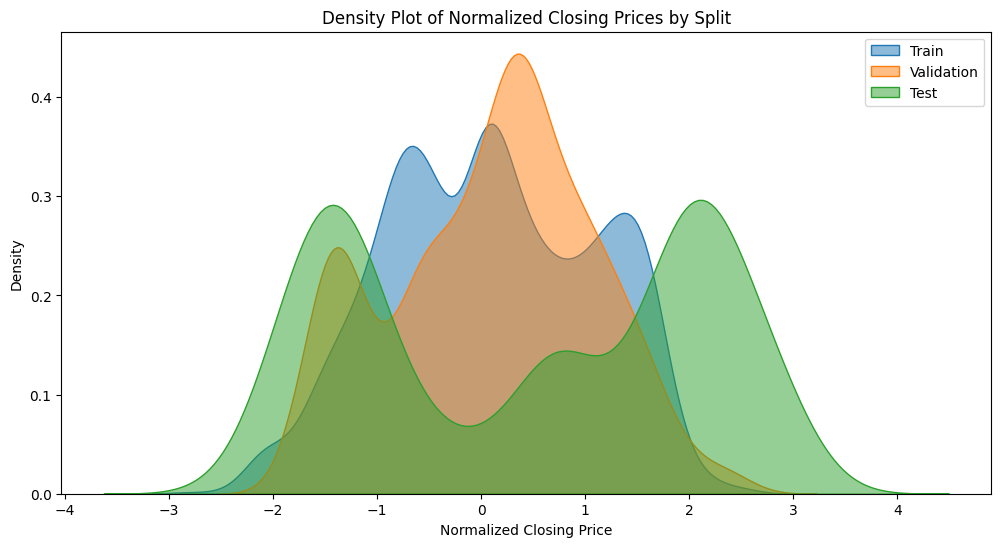

In [5]:

# Combine dates and normalized closing prices for the entire dataset
all_dates = np.concatenate([dates_train, dates_val, dates_test])
all_normalized_prices = np.concatenate([y_train, y_val, y_test])
all_labels = np.concatenate([['Train'] * len(y_train), ['Validation'] * len(y_val), ['Test'] * len(y_test)])

all_data_df = pd.DataFrame({
    'Date': all_dates,
    'Normalized Closing Price': all_normalized_prices,
    'Split': all_labels
})



plt.figure(figsize=(12, 6))
for split in ['Train', 'Validation', 'Test']:
    subset = all_data_df[all_data_df['Split'] == split]
    sns.kdeplot(subset['Normalized Closing Price'], label=split, fill=True, alpha=0.5)
plt.title('Density Plot of Normalized Closing Prices by Split')
plt.xlabel('Normalized Closing Price')
plt.ylabel('Density')
plt.legend()
plt.show()



Setting up the model

In [6]:
# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs found: {len(gpus)}")
    try:
        # Set memory growth for the GPU to avoid OOM errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        strategy = tf.distribute.MirroredStrategy()  # Use MirroredStrategy for multiple GPUs
        print("GPUs initialized using MirroredStrategy.")
    except RuntimeError as e:
        print(f"Error initializing GPUs: {e}")
else:
    strategy = tf.distribute.get_strategy()  # Default strategy for CPU
    print("No GPUs found. Using default strategy (CPU).")


GPUs found: 1
GPUs initialized using MirroredStrategy.


In [7]:
def build_model(hp):
    """
    Builds and compiles a CNN-LSTM model based on the provided hyperparameters.
    """
    # Do NOT wrap model building in strategy scope here
    model = Sequential()
    num_features = X_train.shape[2]
    input_shape = (timesteps, num_features)

    # Define hyperparameters for dropout and L2 regularization
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    l2_reg = hp.Float('l2_reg', min_value=1e-6, max_value=1e-2, sampling='log')

    # Number of LSTM layers: 1 to 4
    num_lstm_layers = hp.Int('num_lstm_layers', min_value=1, max_value=4)

    print(f"Building LSTM-only model with {num_lstm_layers} LSTM layers.")

    # Build LSTM layers with unique hyperparameters for each layer
    for i in range(num_lstm_layers):
        units = hp.Choice(f'units_lstm_{i+1}', values=[32, 64, 128, 256])
        print(f"  LSTM Layer {i+1}: {units} units")
        return_sequences = True if i < num_lstm_layers - 1 else False
        if i == 0:
            # Only specify input_shape for the first layer
            model.add(LSTM(
                units=units,
                return_sequences=return_sequences,
                kernel_regularizer=regularizers.l2(l2_reg),
                input_shape=input_shape
            ))
        else:
            # Do not specify input_shape for subsequent layers
            model.add(LSTM(
                units=units,
                return_sequences=return_sequences,
                kernel_regularizer=regularizers.l2(l2_reg)
            ))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    return model


Training the model

In [35]:
class MyTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        """
        Overrides the run_trial method to include batch_size as a hyperparameter.
        """
        hp = trial.hyperparameters
        batch_size = hp.Choice('batch_size', values=[32, 64, 128])
        kwargs['batch_size'] = batch_size
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

# Wrap the tuner and model in the strategy scope
with strategy.scope():
    # Initialize the Tuner
    tuner = MyTuner(
        build_model,
        objective='val_loss',
        max_trials=30,
        executions_per_trial=1,
        directory='hyperparam_tuning',
        project_name='lstm_no_sentiment_V01'
    )

    # Define Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    # Start the Hyperparameter Search
    tuner.search(
        X_train, y_train,
        epochs=30,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        shuffle=False
    )

# Retrieve the Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search for the LSTM-only model is complete.
The optimal number of LSTM layers is {best_hps.get('num_lstm_layers')} with units {[best_hps.get(f'units_lstm_{i+1}') for i in range(best_hps.get('num_lstm_layers'))]}.
The optimal dropout rate is {best_hps.get('dropout_rate')}.
The optimal L2 regularization factor is {best_hps.get('l2_reg')}.
The optimal batch size is {best_hps.get('batch_size')}.
""")

# Save the JSON file into Google Drive
best_hps_dict = best_hps.values  # Convert to dictionary
with open('/content/drive/My Drive/lstm_no_sentiment.json', 'w') as f:
    json.dump(best_hps_dict, f)

Reloading Tuner from hyperparam_tuning/lstm_no_sentiment_V01/tuner0.json

The hyperparameter search for the LSTM-only model is complete.
The optimal number of LSTM layers is 1 with units [64].
The optimal dropout rate is 0.4.
The optimal L2 regularization factor is 3.982185329420908e-06.
The optimal batch size is 32.



Build and train the best model

In [17]:
# Load hyperparameters
with open('/content/drive/My Drive/lstm_no_sentiment.json', 'r') as f:
    loaded_hps_dict = json.load(f)

class MyTuner(kt.RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        """
        Overrides the run_trial method to include batch_size as a hyperparameter.
        """
        hp = trial.hyperparameters
        batch_size = hp.Choice('batch_size', values=[32, 64, 128])
        kwargs['batch_size'] = batch_size
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)


# Wrap the tuner and model in the TPU strategy scope
with strategy.scope():
    #  Initialize the Tuner
    tuner = MyTuner(
        build_model,
        objective='val_loss',
        max_trials=30,
        executions_per_trial=1,
        directory='hyperparam_tuning',
        project_name='lstm_no_sentiment_V01'
    )
    #  Define Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)




Building LSTM-only model with 1 LSTM layers.
  LSTM Layer 1: 32 units


In [20]:
# Load hyperparameters
with open('/content/drive/My Drive/lstm_no_sentiment.json', 'r') as f:
    loaded_hps_dict = json.load(f)


# Reconstruct the HyperParameters object
loaded_hps = HyperParameters()
for key, value in loaded_hps_dict.items():
    loaded_hps.Fixed(key, value)


# Build the model using the loaded hyperparameters
model = tuner.hypermodel.build(loaded_hps)
history = model.fit(
    X_train, y_train,
    epochs=30,  # Consistent with tuner search
    batch_size=32, #optimal after randomsearch, need to fill this in by hand to rerun it
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    shuffle=False
)

Building LSTM-only model with 1 LSTM layers.
  LSTM Layer 1: 64 units
Epoch 1/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0832 - mean_squared_error: 0.0832 - val_loss: 0.0536 - val_mean_squared_error: 0.0536 - learning_rate: 0.0010
Epoch 2/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0457 - val_mean_squared_error: 0.0456 - learning_rate: 0.0010
Epoch 3/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - learning_rate: 0.0010
Epoch 4/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0314 - mean_squared_error: 0.0313 - val_loss: 0.0253 - val_mean_squared_error: 0.0252 - learning_rate: 0.0010
Epoch 5/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0318 - mean_squared_error: 0.0318 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - learning_rate: 0.0010
Epoch 6/30
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0309 - 

Test set valuation PER TICKER

In [21]:
# Make predictions
y_pred_scaled = model.predict(X_test)

len(y_pred_scaled)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


1860

Calculate metrics per ticker

In [22]:
# Dictionaries to store results per ticker
results = {}

# Arrays to store all true and predicted values for overall metrics
all_y_true_scaled = []
all_y_pred_scaled = []

# Iterate over each ticker in the test set
unique_tickers = np.unique(tickers_test)

for ticker in unique_tickers:
    # Get indices for this ticker
    indices = np.where(tickers_test == ticker)[0]

    # Extract the corresponding predictions and true values (scaled)
    y_test_ticker_scaled = y_test[indices]
    y_pred_ticker_scaled = y_pred_scaled[indices]

    # Store for overall metrics
    all_y_true_scaled.extend(y_test_ticker_scaled)
    all_y_pred_scaled.extend(y_pred_ticker_scaled)

    # Calculate metrics for this ticker on scaled data
    mse = mean_squared_error(y_test_ticker_scaled, y_pred_ticker_scaled)
    mae = mean_absolute_error(y_test_ticker_scaled, y_pred_ticker_scaled)
    r2 = r2_score(y_test_ticker_scaled, y_pred_ticker_scaled)

    # Store results
    results[ticker] = {
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'y_true_scaled': y_test_ticker_scaled,
        'y_pred_scaled': y_pred_ticker_scaled,
        'dates': np.array(dates_test)[indices]
    }

Overall results

In [39]:
# Convert lists to numpy arrays
all_y_true_scaled = np.array(all_y_true_scaled)
all_y_pred_scaled = np.array(all_y_pred_scaled)

# Calculate overall metrics on scaled data
overall_mse = mean_squared_error(all_y_true_scaled, all_y_pred_scaled)
overall_mae = mean_absolute_error(all_y_true_scaled, all_y_pred_scaled)
overall_r2 = r2_score(all_y_true_scaled, all_y_pred_scaled)

print("Overall Metrics (on scaled data):")
print(f"MSE: {overall_mse:.6f}")
print(f"MAE: {overall_mae:.6f}")
print(f"R-squared: {overall_r2:.6f}")


Overall Metrics (on scaled data):
MSE: 0.012080
MAE: 0.079788
R-squared: 0.995732


plot actual vs pred. values


Metrics for AUDUSD (on scaled data):
MSE: 0.008433
MAE: 0.067708
R-squared: 0.917481


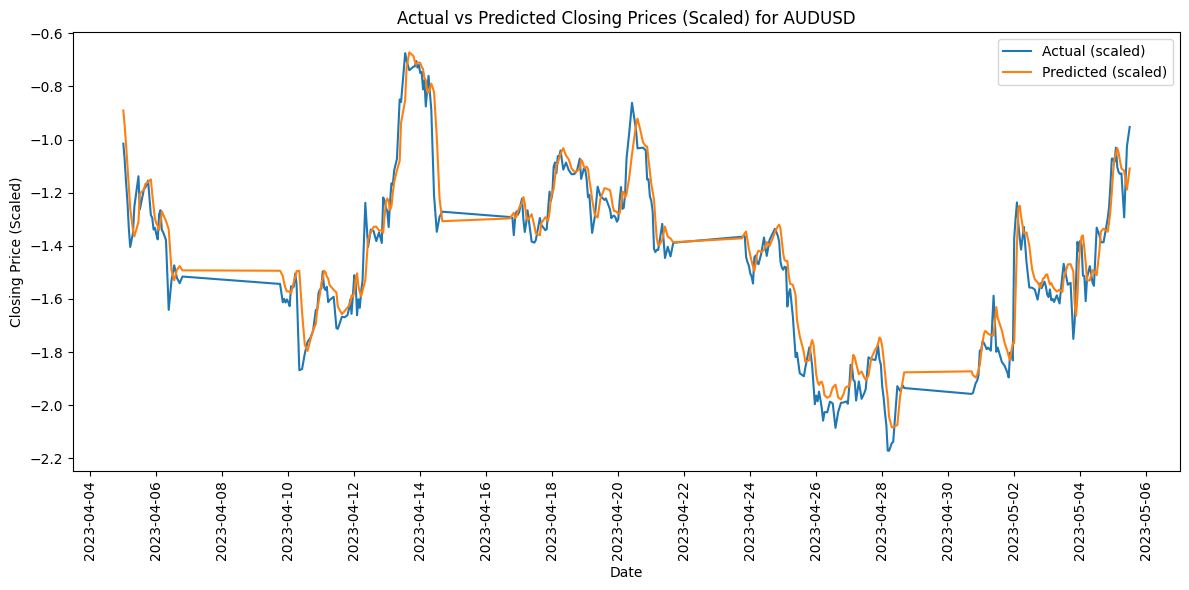


Metrics for EURCHF (on scaled data):
MSE: 0.014263
MAE: 0.084608
R-squared: 0.935098


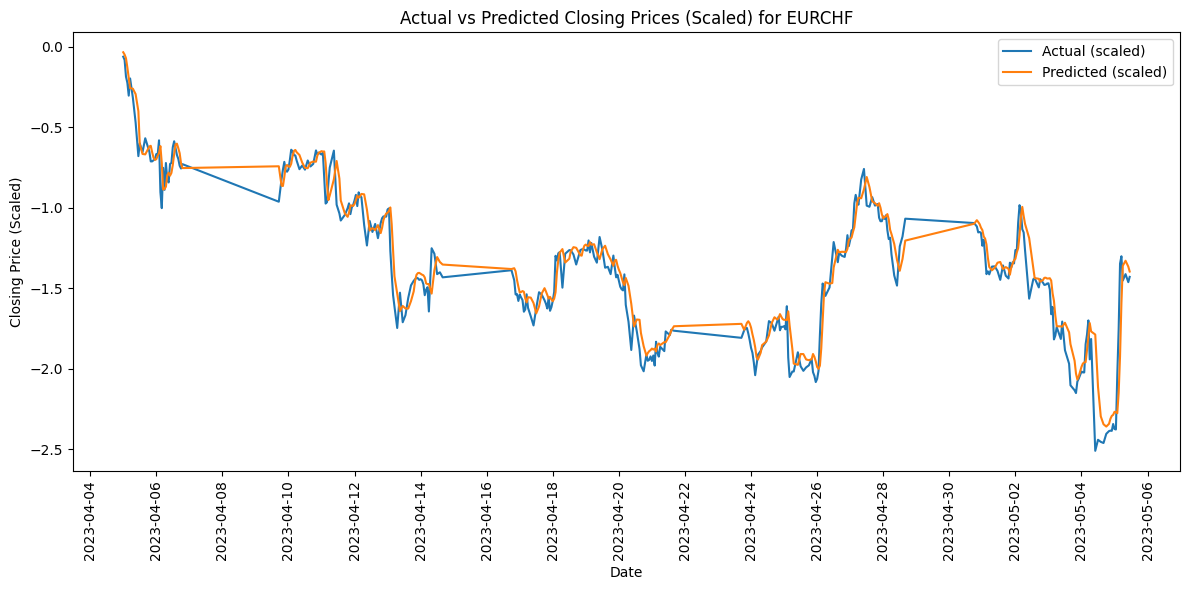


Metrics for EURUSD (on scaled data):
MSE: 0.019842
MAE: 0.107665
R-squared: 0.909321


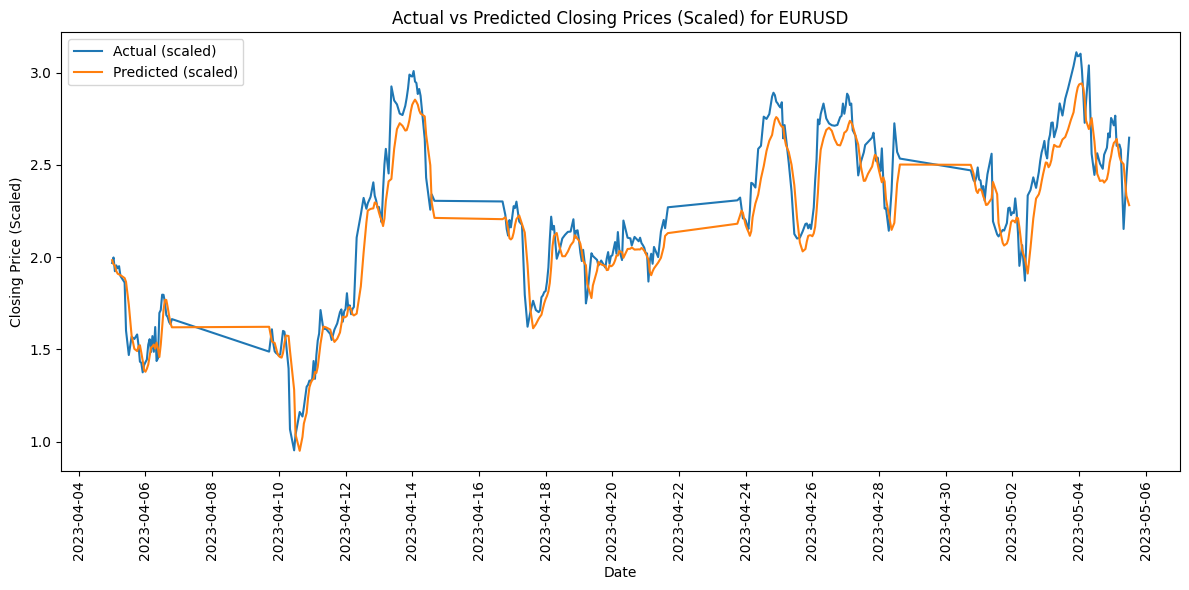


Metrics for GBPUSD (on scaled data):
MSE: 0.016972
MAE: 0.097572
R-squared: 0.886083


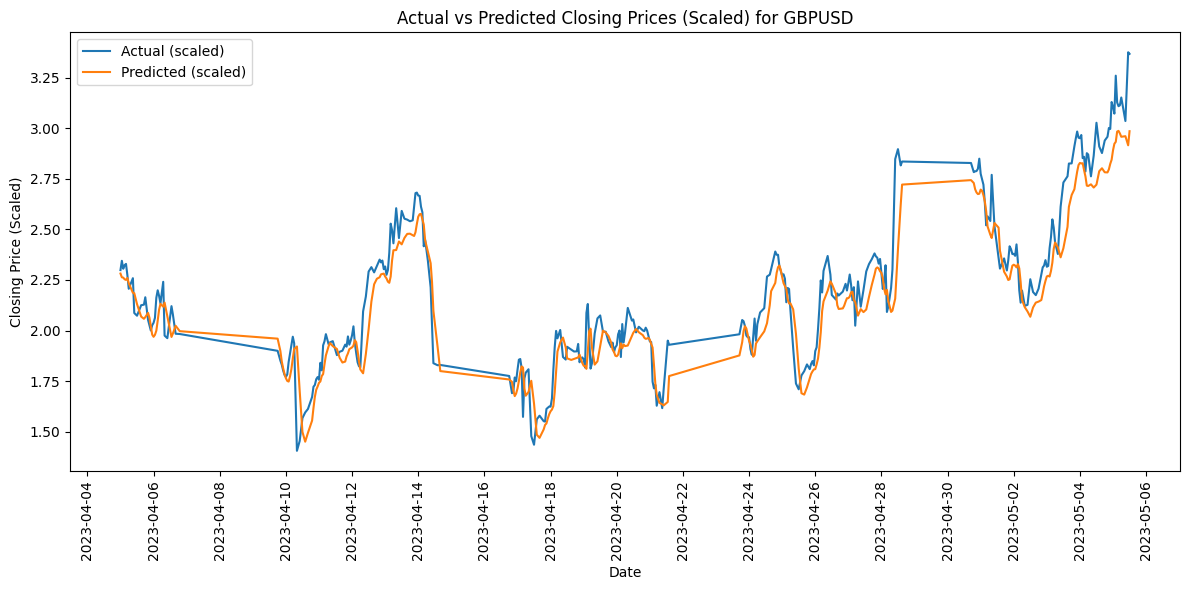


Metrics for USDJPY (on scaled data):
MSE: 0.008435
MAE: 0.061994
R-squared: 0.973676


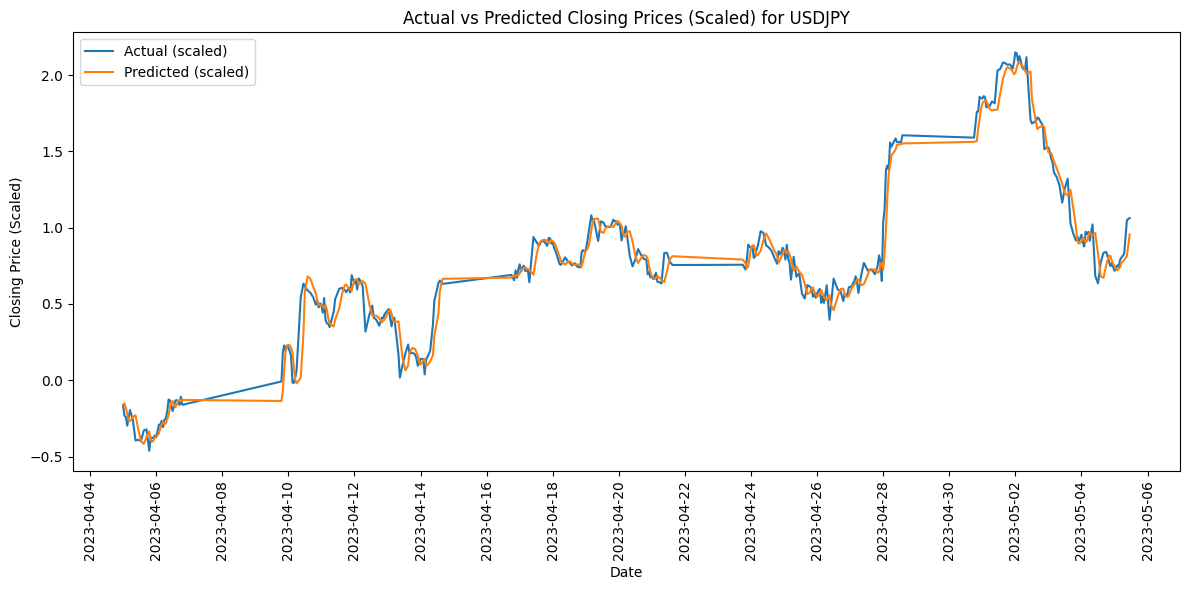

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
for ticker in results.keys():
    print(f"\nMetrics for {ticker} (on scaled data):")
    print(f"MSE: {results[ticker]['mse']:.6f}")
    print(f"MAE: {results[ticker]['mae']:.6f}")
    print(f"R-squared: {results[ticker]['r2']:.6f}")

    # Plot actual vs predicted values (scaled)
    plt.figure(figsize=(12, 6))
    plt.plot(results[ticker]['dates'], results[ticker]['y_true_scaled'], label='Actual (scaled)')
    plt.plot(results[ticker]['dates'], results[ticker]['y_pred_scaled'], label='Predicted (scaled)')
    plt.title(f'Actual vs Predicted Closing Prices (Scaled) for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (Scaled)')
    plt.legend()

    # Format the x-axis to show every
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Set major ticks every
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as Year-Month-Day

    # Rotate the x-axis labels to vertical
    plt.xticks(rotation=90)

    # Include start and end date annotations
    start_date = results[ticker]['dates'].min()
    end_date = results[ticker]['dates'].max()



    # Remove gridlines
    plt.grid(False)

    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()

    plt.show()




# Testing profitability

Inverse transform predictions and actual values

In [23]:
# Dictionary to store strategy results per ticker
strategy_results = {}

for ticker in results.keys():
    # Extract data for this ticker
    indices = np.where(tickers_test == ticker)[0]
    dates = results[ticker]['dates']
    y_test_ticker_scaled = results[ticker]['y_true_scaled']
    y_pred_ticker_scaled = results[ticker]['y_pred_scaled']

    # Inverse transform using the target_scaler for this ticker
    target_scaler = target_scalers[ticker]
    y_test_ticker = target_scaler.inverse_transform(y_test_ticker_scaled.reshape(-1, 1)).flatten()
    y_pred_ticker = target_scaler.inverse_transform(y_pred_ticker_scaled.reshape(-1, 1)).flatten()

    # Create a DataFrame
    df_strategy = pd.DataFrame({
        'Date': dates,
        'Actual_Close': y_test_ticker,
        'Predicted_Close': y_pred_ticker
    })
    df_strategy.sort_values('Date', inplace=True)
    df_strategy.reset_index(drop=True, inplace=True)

    # Get the original df for this ticker
    df_original = data[data['ticker'] == ticker].copy()
    df_original = df_original.sort_values('Date')
    df_original.reset_index(drop=True, inplace=True)

    # Keep only Date and closing_price
    df_original = df_original[['Date', 'closing_price']]

    # Create 'Actual_Close_Shifted' in df_original
    df_original['Actual_Close_Shifted'] = df_original['closing_price'].shift(1)

    # Merge df_strategy with df_original to get 'Actual_Close_Shifted'
    df_strategy = df_strategy.merge(df_original[['Date', 'Actual_Close_Shifted']], on='Date', how='left')

    # Drop rows with NaN in 'Actual_Close_Shifted'
    df_strategy.dropna(subset=['Actual_Close_Shifted'], inplace=True)

    # Generate signals
    df_strategy['Signal'] = np.where(
        df_strategy['Predicted_Close'] > df_strategy['Actual_Close_Shifted'], 1, -1)

    # Calculate returns based on actual closing prices
    df_strategy['Return'] = df_strategy['Actual_Close'].pct_change()
    df_strategy['Return'].fillna(0, inplace=True)


    # Strategy returns: use signal from t-1 to calculate return from t-1 to t
    df_strategy['Strategy_Return'] =  df_strategy['Signal'].shift(1) * df_strategy['Return']

    # Drop NaN values resulting from shifting signals
    df_strategy.dropna(subset=['Strategy_Return'], inplace=True)

    # Store the DataFrame
    strategy_results[ticker] = df_strategy

<ipython-input-23-035fab1edf2f>:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_strategy['Return'].fillna(0, inplace=True)
<ipython-input-23-035fab1edf2f>:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

Implementing strategy per ticker


Performance Metrics for AUDUSD:
Annualized Return: 25.28%
Annualized Volatility: 12.32%
Sharpe Ratio: 1.89

Performance Metrics for EURCHF:
Annualized Return: 7.90%
Annualized Volatility: 5.71%
Sharpe Ratio: 1.03

Performance Metrics for EURUSD:
Annualized Return: 10.07%
Annualized Volatility: 8.41%
Sharpe Ratio: 0.96

Performance Metrics for GBPUSD:
Annualized Return: -5.31%
Annualized Volatility: 8.66%
Sharpe Ratio: -0.84

Performance Metrics for USDJPY:
Annualized Return: 6.67%
Annualized Volatility: 12.13%
Sharpe Ratio: 0.39


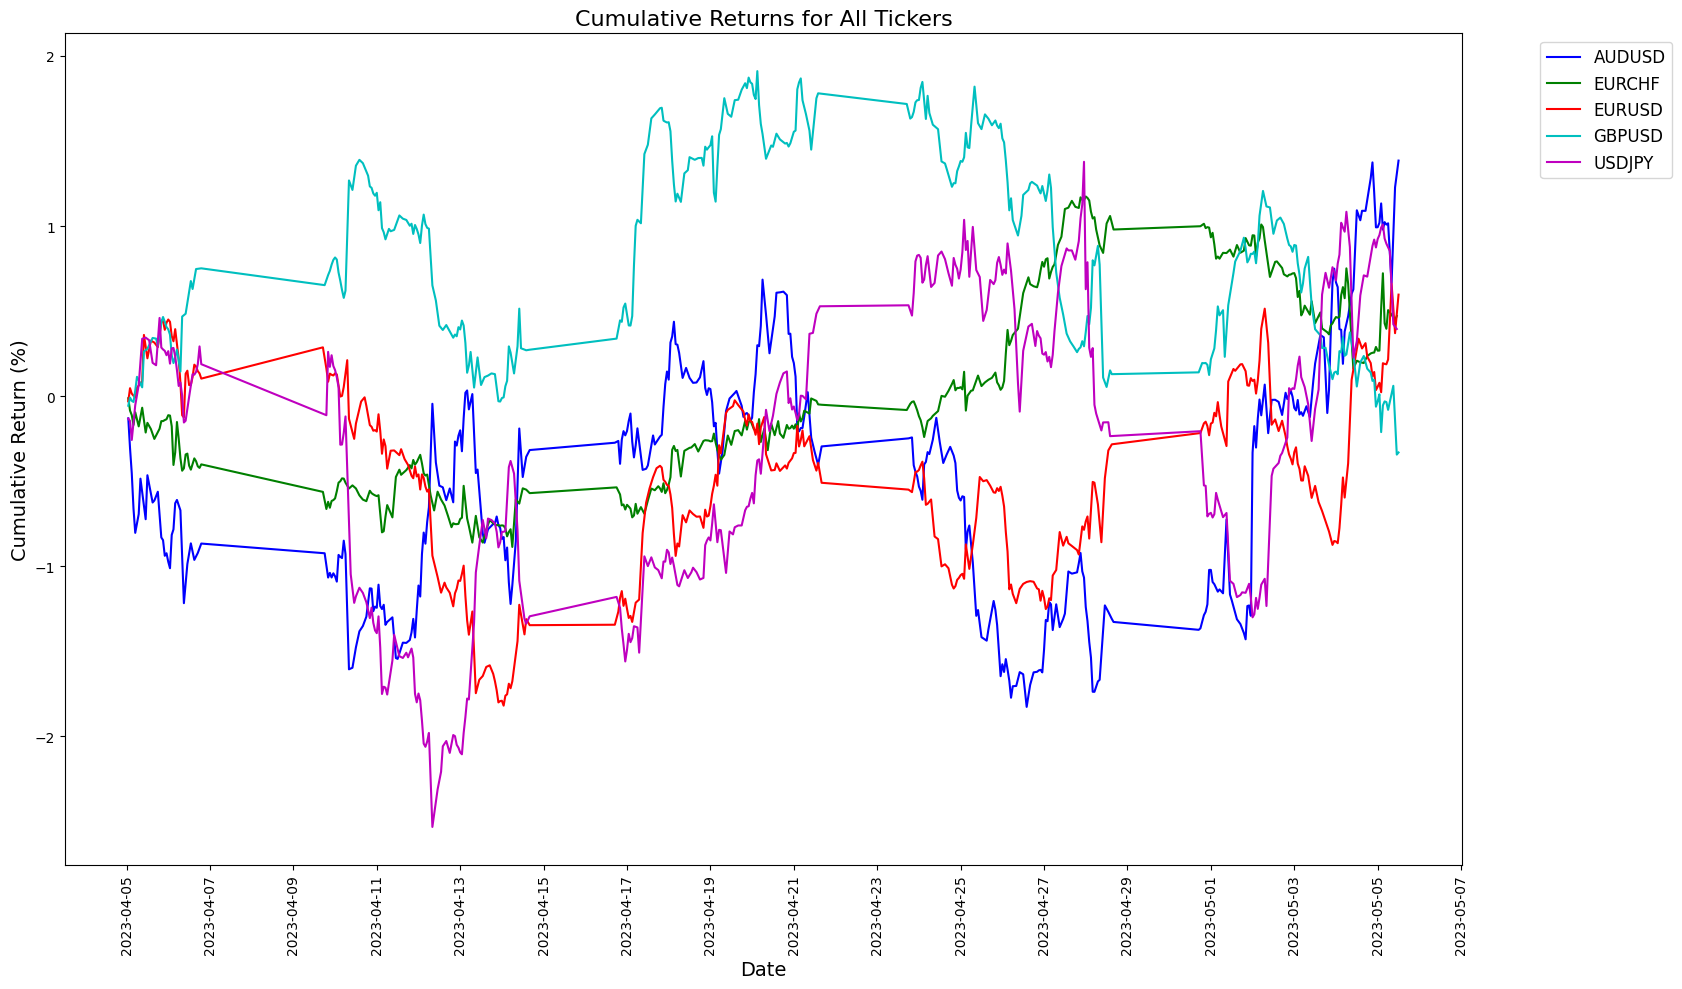

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import itertools

# Define constants for calculations
risk_free_rate = 0.02  # Risk-free rate as a decimal (2%)
periods_per_year = 252 * 24  # Forex trading hours in a year (assumed: 252 trading days * 24 hours)
hours_per_year = 252 * 24

# Initialize a dictionary to store performance metrics per ticker
performance_metrics = {}

# Initialize a dictionary to collect cumulative returns for all tickers
all_cumulative_returns = {}
all_dates = []

for ticker, df_strategy in strategy_results.items():
    # Ensure 'Date' is in datetime format
    df_strategy['Date'] = pd.to_datetime(df_strategy['Date'])

    # Sort by Date to ensure proper cumulative calculation
    df_strategy = df_strategy.sort_values('Date')

    # Calculate cumulative return starting at 0%
    df_strategy['Cumulative_Return'] = (1 + df_strategy['Strategy_Return']).cumprod() - 1

    # Total number of periods (number of strategy returns)
    total_periods = len(df_strategy)

    # Calculate cumulative return over the test period
    cumulative_return = df_strategy['Cumulative_Return'].iloc[-1]

    # Annualized Return
    annualized_return = (1 + cumulative_return) ** (periods_per_year / total_periods) - 1

    # Annualized Volatility
    annualized_volatility = df_strategy['Strategy_Return'].std() * np.sqrt(periods_per_year)

    # Sharpe Ratio
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else np.nan

    # Store performance metrics
    performance_metrics[ticker] = {
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio
    }

    # Print performance metrics per ticker
    print(f"\nPerformance Metrics for {ticker}:")
    print(f"Annualized Return: {annualized_return*100:.2f}%")
    print(f"Annualized Volatility: {annualized_volatility*100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

    # Collect data for plotting
    all_cumulative_returns[ticker] = df_strategy[['Date', 'Cumulative_Return']].copy()

    # Collect all dates to determine overall start and end
    all_dates.extend(df_strategy['Date'].tolist())

# Determine overall start and end dates
overall_start_date = min(all_dates)
overall_end_date = max(all_dates)

# Determine overall y-axis limits with some padding
all_cum_returns_flat = [ret for df in all_cumulative_returns.values() for ret in df['Cumulative_Return']]
y_min = (min(all_cum_returns_flat) * 100) - 1  # Adding padding
y_max = (max(all_cum_returns_flat) * 100) + 1  # Adding padding

# Initialize the plot
plt.figure(figsize=(20, 10))

# Define a color cycle to differentiate tickers
colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown'])

# Plot cumulative returns for each ticker
for ticker, df in all_cumulative_returns.items():
    color = next(colors)
    plt.plot(df['Date'], df['Cumulative_Return'] * 100, label=f'{ticker}', color=color)

# Set the title and labels
plt.title('Cumulative Returns for All Tickers', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return (%)', fontsize=14)

# Configure the x-axis to show every 2 days with vertical labels
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Major ticks every 2 days
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as Year-Month-Day

# Rotate the x-axis labels to vertical
plt.xticks(rotation=90)

# Include start and end date annotations
plt.annotate('Start', xy=(overall_start_date, y_min),
             xytext=(overall_start_date, y_min),
             textcoords="offset points",
             ha='center', va='bottom',
             arrowprops=dict(arrowstyle='->', color='green'))

plt.annotate('End', xy=(overall_end_date, y_max),
             xytext=(overall_end_date, y_max),
             textcoords="offset points",
             ha='center', va='bottom',
             arrowprops=dict(arrowstyle='->', color='red'))

# Remove gridlines
plt.grid(False)

# Add a comprehensive legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Adjust layout to prevent clipping of tick-labels and legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Display the plot
plt.show()

Overall profitability


Overall Portfolio Performance:
Annualized Return: 6.40%
Annualized Volatility: 3.67%
Sharpe Ratio: 1.74


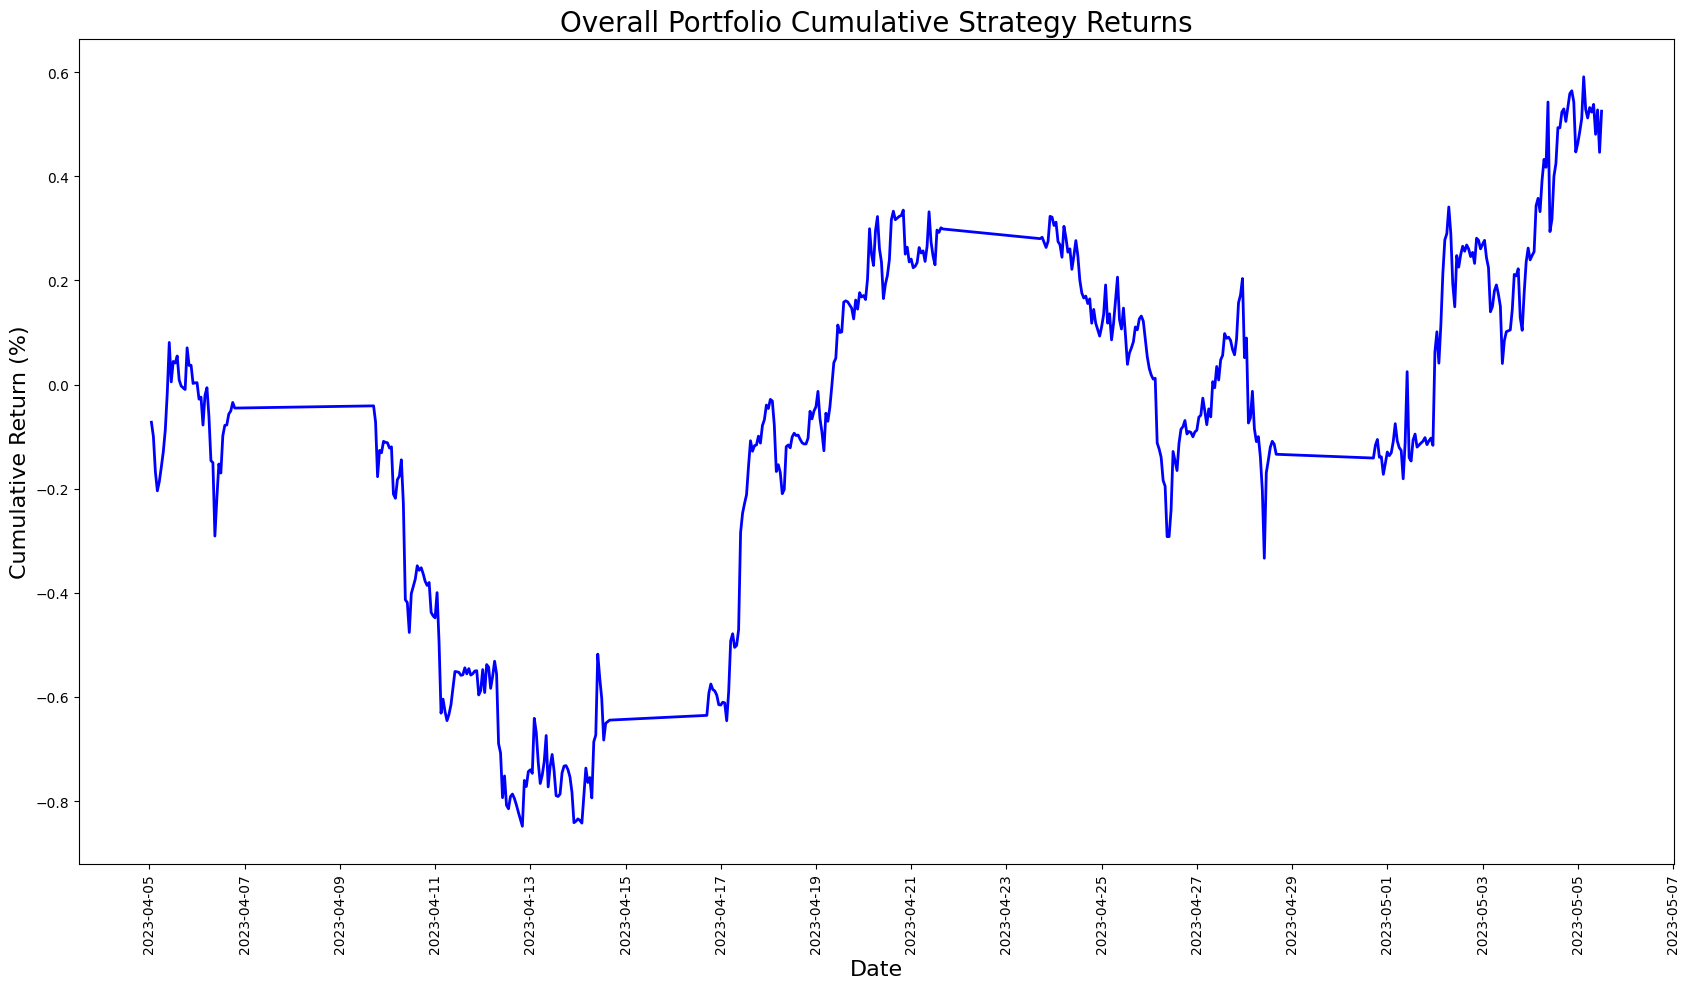

In [25]:
# Initialize an empty DataFrame to store all strategy returns
portfolio_df = pd.DataFrame()

for ticker, df_strategy in strategy_results.items():
    # Ensure 'Date' is in datetime format
    df_strategy['Date'] = pd.to_datetime(df_strategy['Date'])

    # Select relevant columns and rename 'Strategy_Return' to include the ticker name
    df_temp = df_strategy[['Date', 'Strategy_Return']].copy()
    df_temp.rename(columns={'Strategy_Return': f'Strategy_Return_{ticker}'}, inplace=True)

    # Merge with the portfolio DataFrame on 'Date'
    if portfolio_df.empty:
        portfolio_df = df_temp
    else:
        portfolio_df = pd.merge(portfolio_df, df_temp, on='Date', how='outer')

# Sort the portfolio DataFrame by Date
portfolio_df.sort_values('Date', inplace=True)
portfolio_df.reset_index(drop=True, inplace=True)

# Fill NaN values with 0, assuming no return if no trade occurred
portfolio_df.fillna(0, inplace=True)

# Calculate the Portfolio Strategy_Return as the average of all tickers' Strategy_Return
strategy_columns = [col for col in portfolio_df.columns if col.startswith('Strategy_Return_')]
portfolio_df['Portfolio_Return'] = portfolio_df[strategy_columns].mean(axis=1)

# Calculate Cumulative Return for the Portfolio
portfolio_df['Cumulative_Return'] = (1 + portfolio_df['Portfolio_Return']).cumprod() - 1

# Calculate Total Cumulative Return
total_cumulative_return = (1 + portfolio_df['Portfolio_Return']).prod() - 1

# Calculate Annualized Return
annualized_return = 100 * ((1 + total_cumulative_return) ** (hours_per_year / len(portfolio_df)) - 1)

# Calculate Annualized Volatility
annualized_volatility = 100 * portfolio_df['Portfolio_Return'].std() * np.sqrt(hours_per_year)

# Calculate Sharpe Ratio
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility if annualized_volatility != 0 else np.nan

print("\nOverall Portfolio Performance:")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Annualized Volatility: {annualized_volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# --- Plotting Section ---

# Determine overall start and end dates
overall_start_date = portfolio_df['Date'].min()
overall_end_date = portfolio_df['Date'].max()

# Determine y-axis limits with some padding
y_min = (portfolio_df['Cumulative_Return'].min() * 100) - 1  # Adding padding
y_max = (portfolio_df['Cumulative_Return'].max() * 100) + 1  # Adding padding

# Initialize the plot
plt.figure(figsize=(20, 10))

# Plot the Overall Cumulative Strategy Returns
plt.plot(portfolio_df['Date'], portfolio_df['Cumulative_Return'] * 100,
         label='Portfolio Cumulative Return', color='blue', linewidth=2)

# Set the title and labels
plt.title('Overall Portfolio Cumulative Strategy Returns', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Cumulative Return (%)', fontsize=16)

# Configure the x-axis to show every 2 days with vertical labels
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Major ticks every 2 days
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as Year-Month-Day

# Rotate the x-axis labels to vertical
plt.xticks(rotation=90)

# Include start and end date annotations
plt.annotate('Start', xy=(overall_start_date, y_min),
             xytext=(overall_start_date, y_min),
             textcoords="offset points",
             ha='center', va='bottom',
             arrowprops=dict(arrowstyle='->', color='green'))

plt.annotate('End', xy=(overall_end_date, y_max),
             xytext=(overall_end_date, y_max),
             textcoords="offset points",
             ha='center', va='bottom',
             arrowprops=dict(arrowstyle='->', color='red'))

# Remove gridlines
plt.grid(False)



# Adjust layout to prevent clipping of tick-labels and legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Display the plot
plt.show()




In [47]:


# Make Predictions on Training and Validation Sets
y_pred_train_scaled = model.predict(X_train)
y_pred_val_scaled = model.predict(X_val)

# If predictions are multi-dimensional, flatten them to 1D arrays
if y_pred_train_scaled.ndim > 1:
    y_pred_train_scaled = y_pred_train_scaled.flatten()
if y_pred_val_scaled.ndim > 1:
    y_pred_val_scaled = y_pred_val_scaled.flatten()

# 2. Calculate Metrics for Training Set
mse_train = mean_squared_error(y_train, y_pred_train_scaled)
mae_train = mean_absolute_error(y_train, y_pred_train_scaled)
r2_train = r2_score(y_train, y_pred_train_scaled)

# 3. Calculate Metrics for Validation Set
mse_val = mean_squared_error(y_val, y_pred_val_scaled)
mae_val = mean_absolute_error(y_val, y_pred_val_scaled)
r2_val = r2_score(y_val, y_pred_val_scaled)

# 4. Print Metrics
print("\n--- Overall Metrics ---")

print("\nTraining Set Metrics (on scaled data):")
print(f"MSE: {mse_train:.6f}")
print(f"MAE: {mae_train:.6f}")
print(f"R-squared: {r2_train:.6f}")

print("\nValidation Set Metrics (on scaled data):")
print(f"MSE: {mse_val:.6f}")
print(f"MAE: {mae_val:.6f}")
print(f"R-squared: {r2_val:.6f}")


164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Overall Metrics ---

Training Set Metrics (on scaled data):
MSE: 0.012796
MAE: 0.075301
R-squared: 0.987333

Validation Set Metrics (on scaled data):
MSE: 0.013674
MAE: 0.079707
R-squared: 0.985443
